### Import des bibliothéques
---

In [ ]:
import os
import boto3
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine, text

### Chargement secrets.env et connection à S3
---

In [2]:
load_dotenv("secrets.env")

AWS_KEY = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET = os.getenv("AWS_SECRET_ACCESS_KEY")
BUCKET_NAME = os.getenv("AWS_BUCKET_NAME")
NEON_CONN = os.getenv("NEON_CONN")

s3 = boto3.client(
    "s3",
    aws_access_key_id=AWS_KEY,
    aws_secret_access_key=AWS_SECRET
)


### Chargement fichier csv du S3
---

In [3]:
# chargement fichier du S3
s3.download_file(BUCKET_NAME, "df_meteo.csv", "meteoS3.csv")
s3.download_file(BUCKET_NAME, "df_top20_hotel.csv", "hotelS3.csv")
s3.download_file(BUCKET_NAME, "df_ville.csv", "villeS3.csv")

# Lecture des fichiers 
df_hotelS3 = pd.read_csv("hotelS3.csv")
df_meteoS3 = pd.read_csv("meteoS3.csv")
df_villeS3 = pd.read_csv("villeS3.csv")

display(df_hotelS3.head())
display(df_meteoS3.head())
display(df_villeS3.head())

,name,description,url,latitude,longitude,score,id_hotel,nom_ville,id_ville
0,Résidence Odalys Fleur de Sel,"Situé à Aigues-Mortes, à 5 minutes à pied du c...",https://www.booking.com/hotel/fr/residence-oda...,43.574094,4.179246,8.3,1,Aigues Mortes,26.0
1,Résidence Odalys Le Mas des Flamants,Située à l'extérieur des fortifications d'Aigu...,https://www.booking.com/hotel/fr/residence-le-...,43.573794,4.180622,8.4,2,Aigues Mortes,26.0
2,Hôtel Saint Louis,"Situé dans le cœur historique d'Aigues-Mortes,...",https://www.booking.com/hotel/fr/saint-louis-a...,43.567220,4.189344,8.5,3,Aigues Mortes,26.0
3,Maison T4 -Jardin+ Parking+ Clim -Proche Remparts,L’hébergement Maison T4 -Jardin+ Parking+ Clim...,https://www.booking.com/hotel/fr/maison-t4-jar...,43.565819,4.205353,8.6,4,Aigues Mortes,26.0
4,Hôtel les jardins du canal - piscine chauffée ...,L’hôtel Canal Aigues Mortes vous accueille sur...,https://www.booking.com/hotel/fr/canal-aigues-...,43.572988,4.194825,8.7,5,Aigues Mortes,26.0


,nom_ville,latitude,longitude,date,periode_journee,condition_meteo,temperature,id_ville,id_meteo
0,Huisnes-sur-Mer,48.635954,-1.51146,2025-10-01,Matin,couvert,15,1,1
1,Huisnes-sur-Mer,48.635954,-1.51146,2025-10-01,Après-midi,couvert,18,1,2
2,Huisnes-sur-Mer,48.635954,-1.51146,2025-10-02,Matin,couvert,16,1,3
3,Huisnes-sur-Mer,48.635954,-1.51146,2025-10-02,Après-midi,couvert,21,1,4
4,Huisnes-sur-Mer,48.635954,-1.51146,2025-10-03,Matin,légère pluie,17,1,5


,nom_ville,latitude,longitude,id_ville
0,Mont Saint Michel,48.635954,-1.511460,1
1,St Malo,48.649518,-2.026041,2
2,Bayeux,49.276462,-0.702474,3
3,Le Havre,49.493898,0.107973,4
4,Rouen,49.440459,1.093966,5


### Création table SQL Neon
---

In [56]:
engine = create_engine(os.environ["NEON_CONN"])

In [57]:
sql_create_table="""

CREATE TABLE villes (
    id_ville INT PRIMARY KEY,
    nom_ville VARCHAR(100) NOT NULL,
    latitude DECIMAL(9,6),
    longitude DECIMAL(9,6)
);


CREATE TABLE hotels (
    id_hotel INT PRIMARY KEY,
    id_ville INT REFERENCES villes(id_ville),
    name VARCHAR(255),
    description TEXT,
    url TEXT,
    score DECIMAL(3,2)
);


CREATE TABLE meteo (
    id_meteo INT PRIMARY KEY,
    id_ville INT REFERENCES villes(id_ville),
    date DATE,
    periode_journee VARCHAR(20), -- Matin / Après-midi
    condition_meteo VARCHAR(255),
    temperature DECIMAL(4,1)
);
"""
# Exécution
with engine.begin() as conn:
    conn.execute(text(sql_create_table))

print("Tables créées avec succès sur Neon !")


Tables créées avec succès sur Neon !


### Nettoyer table Méteo et Hotel pour éviter la redondance des données
---

In [54]:
# sup col 'nom_ville', 'latitude' et 'longitude' déjà présente ds table 'villes'
df_hotelS3 = df_hotelS3.drop(columns=['nom_ville', 'latitude','longitude'])
df_meteoS3 = df_meteoS3.drop(columns=['nom_ville','latitude','longitude' ])


### Chargement des données dans les tables SQL
---

In [58]:
df_villeS3.to_sql("villes", engine, if_exists="append", index=False)
df_hotelS3.to_sql("hotels", engine, if_exists="append", index=False)
df_meteoS3.to_sql("meteo", engine, if_exists="append", index=False)

350

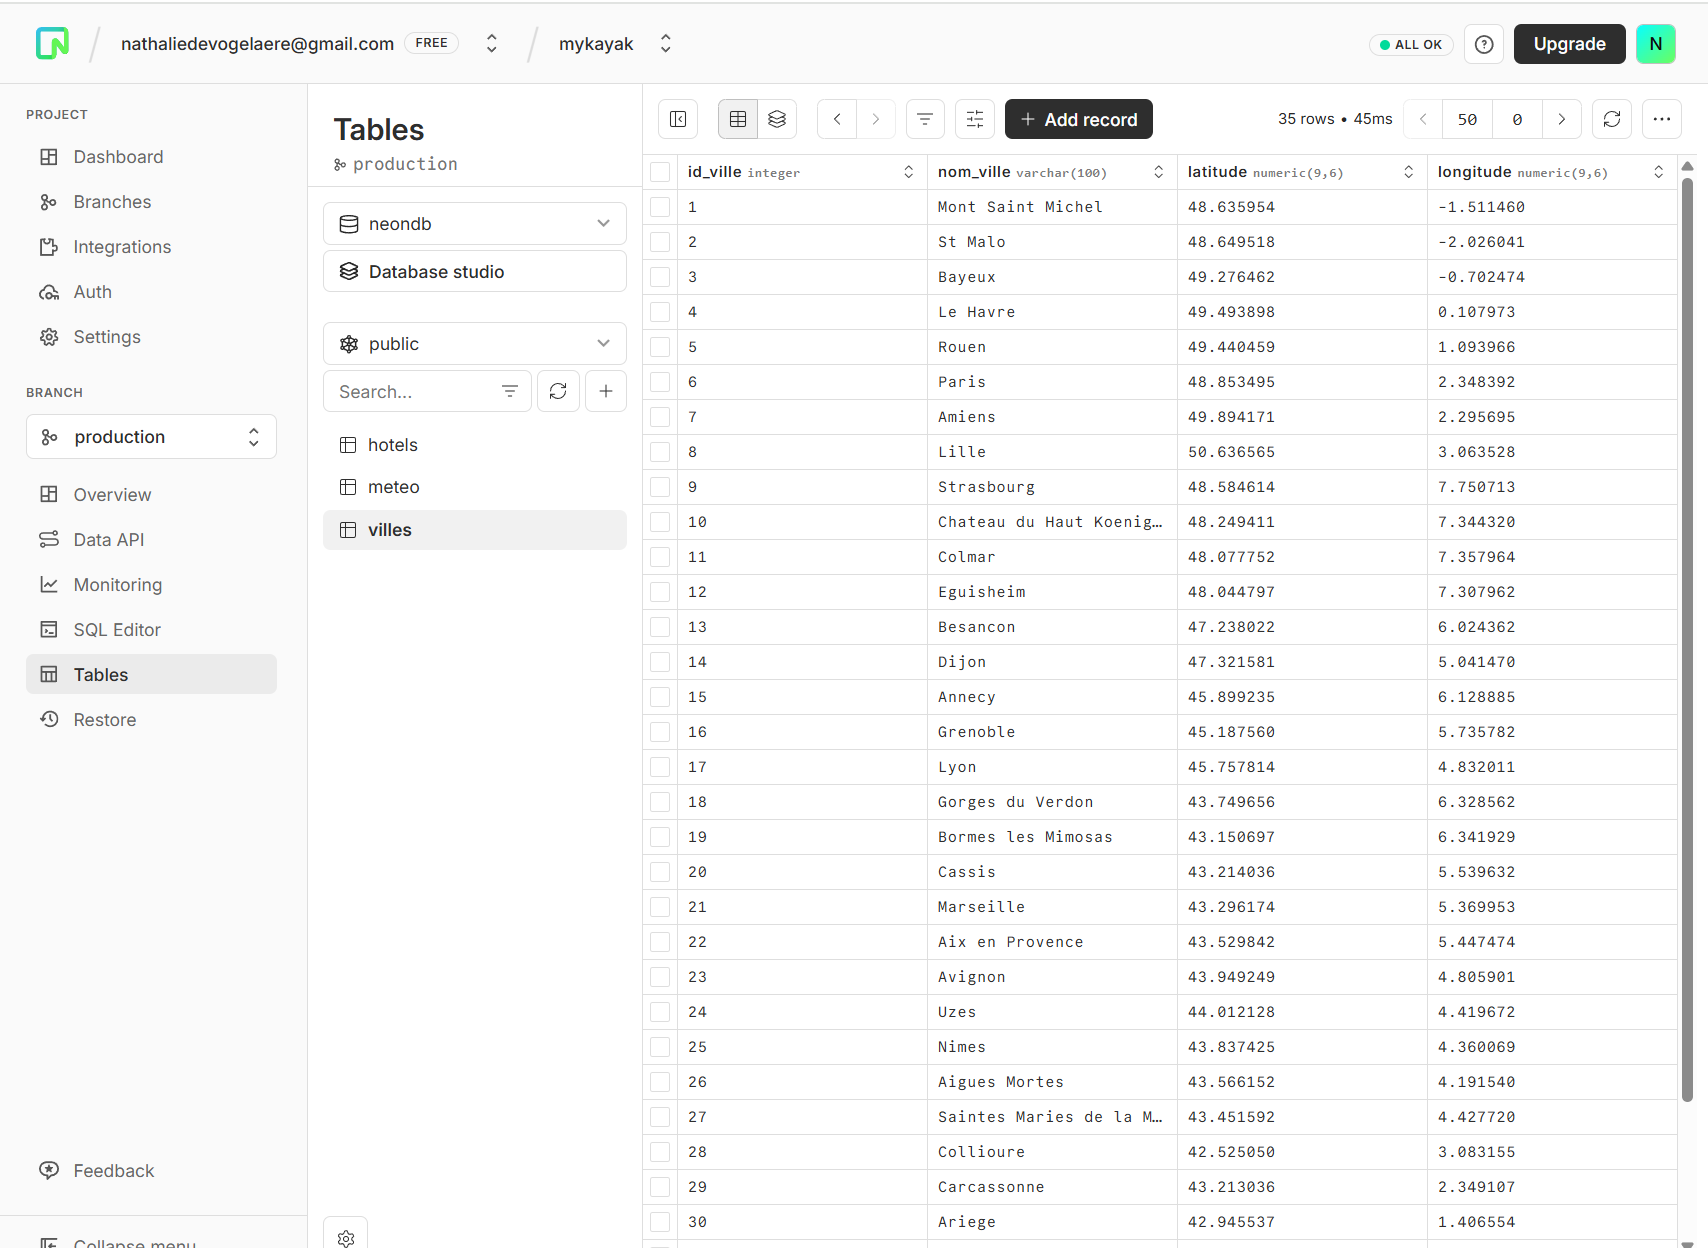

### Requete SQL dans Neon
---

#### Table villes selectionne les 10 preliéres 

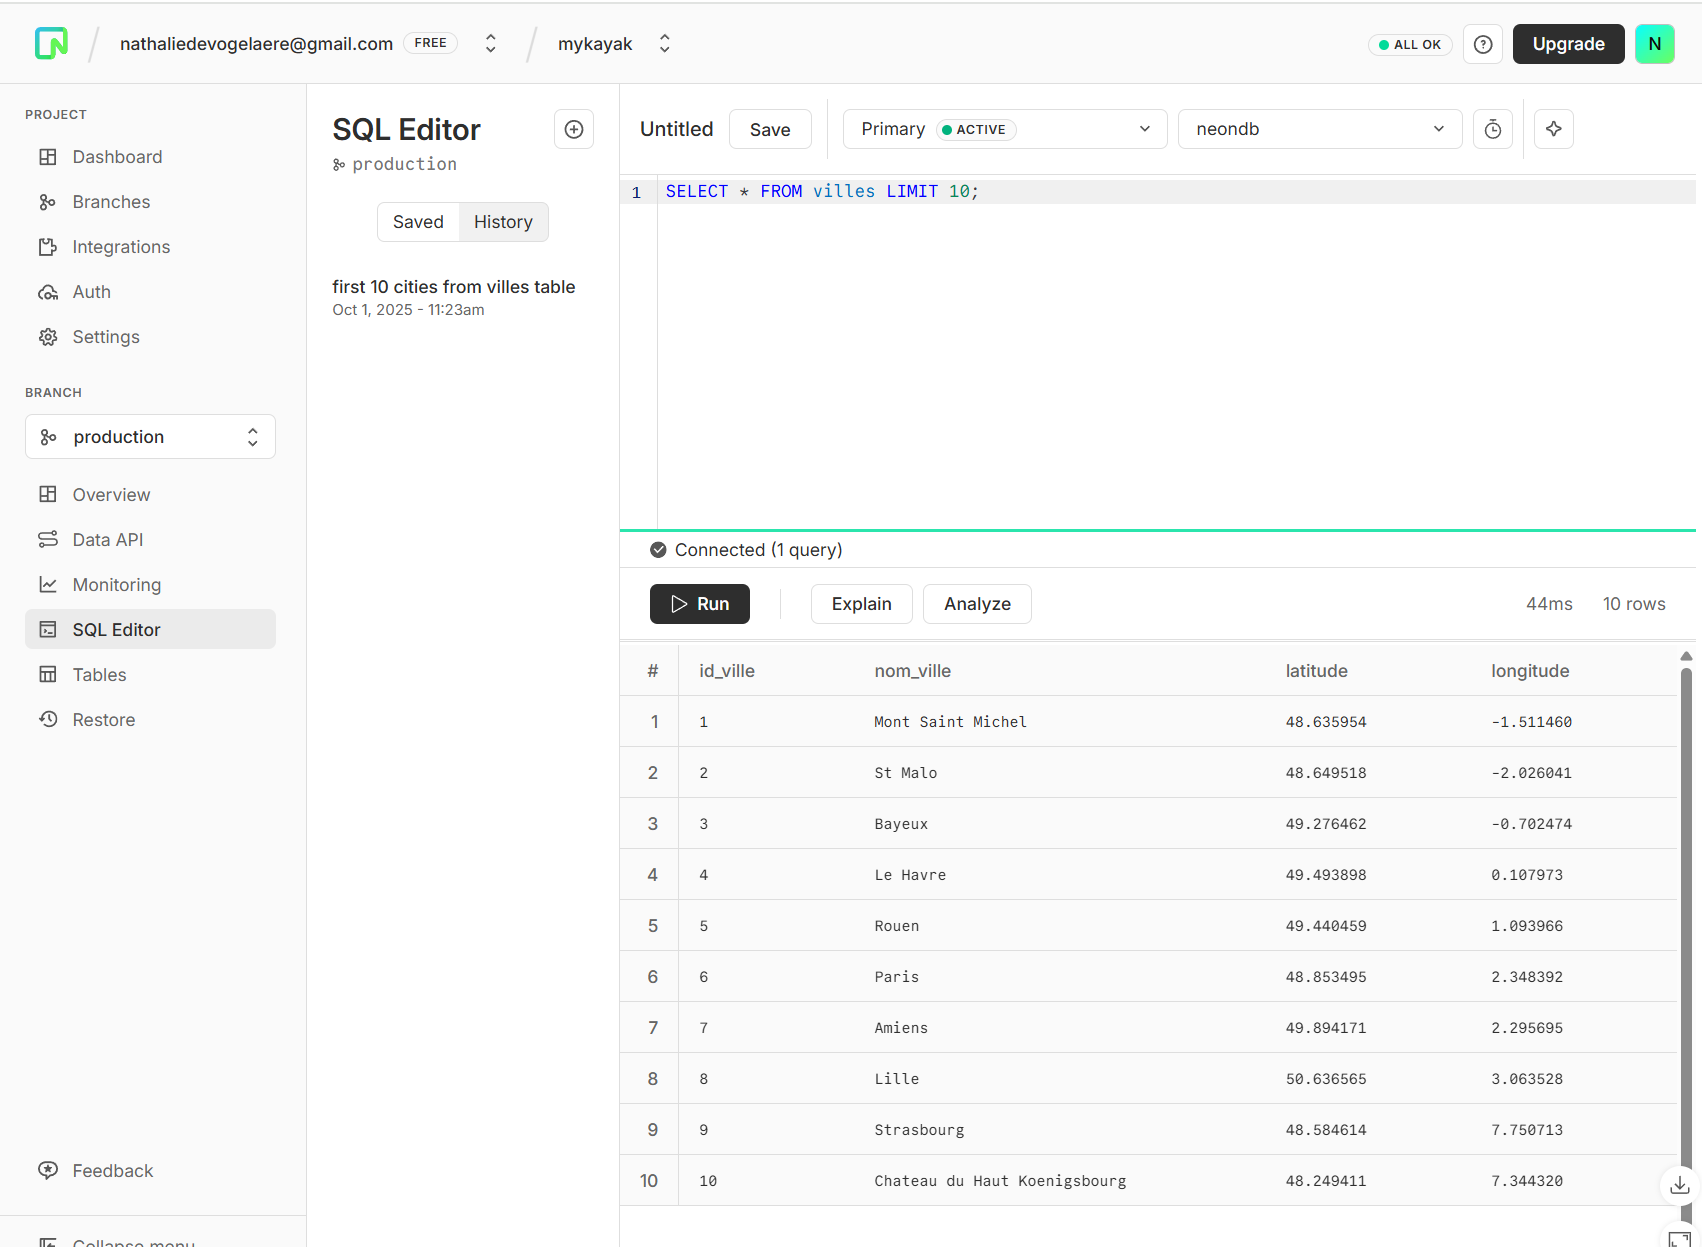

####  Top 5 des villes ou il fait le plus chaud

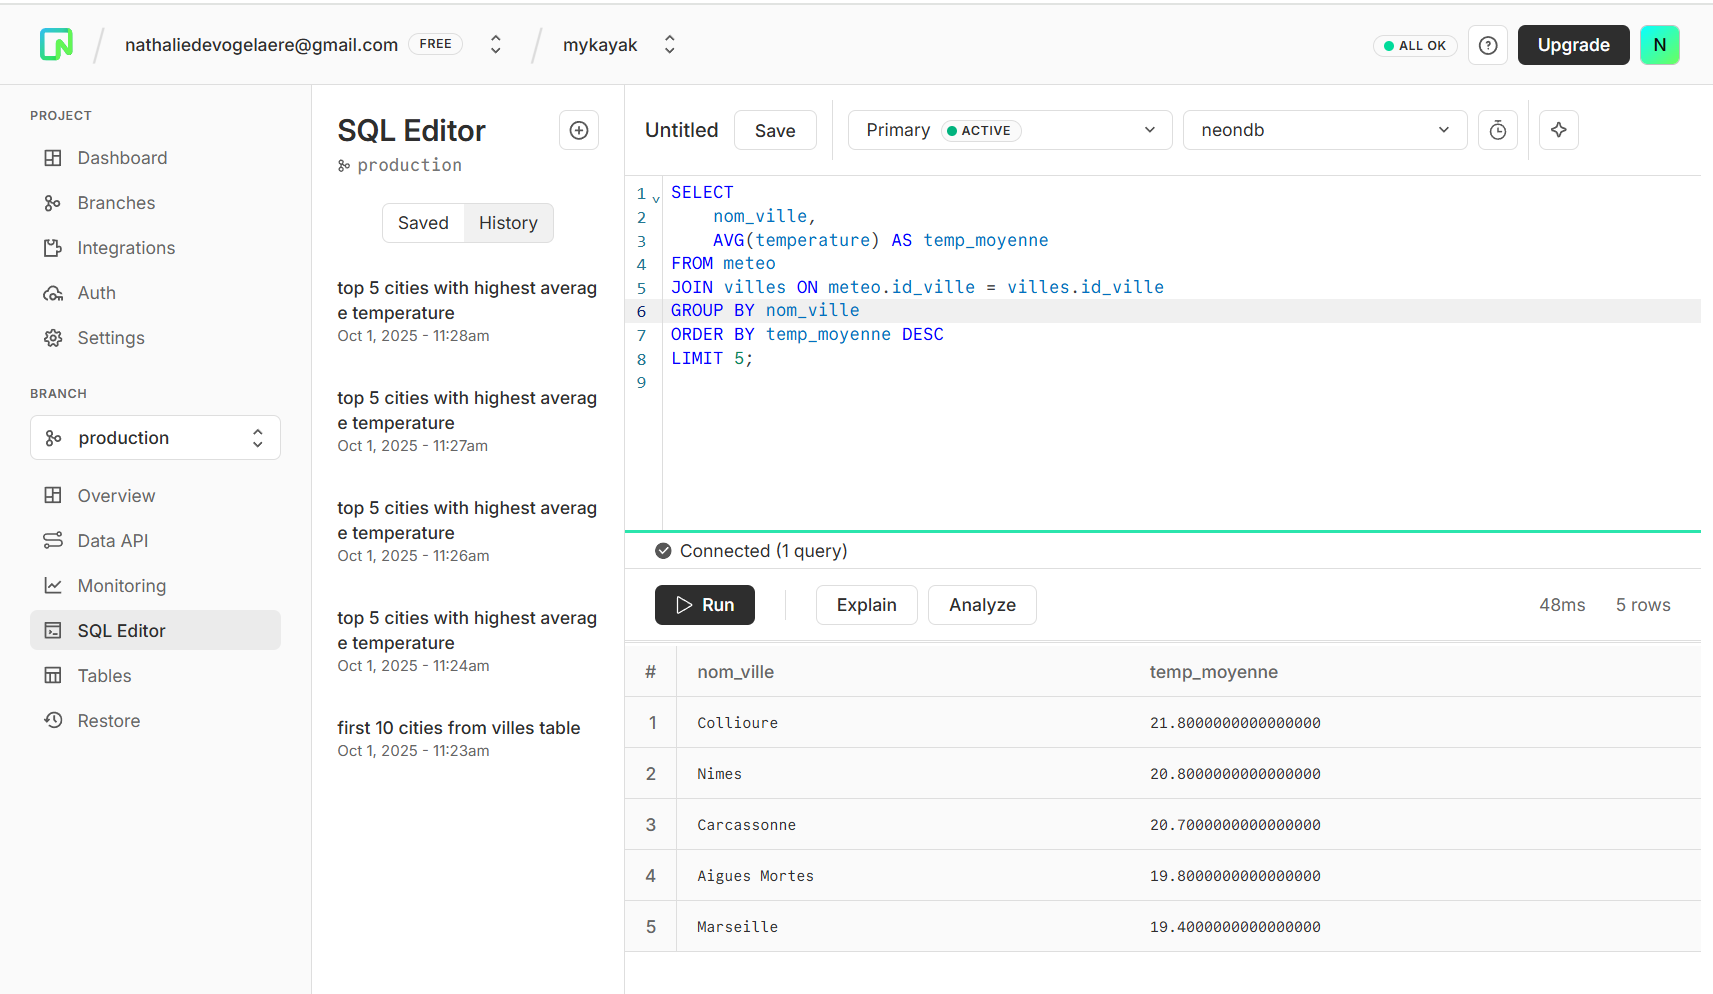